In [1]:
%matplotlib inline

import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

DATA_RAW = Path(os.getcwd()) / os.pardir / "data" / "raw" / "consumption"
DATA_FINAL = Path(os.getcwd()) / os.pardir / "data" / "final" / "consumption"

# Datasets

 1. Training Conumption - `Given1`
 2. Public Test set - `Given2` (Note, contains all of Given 1 as well)
 3. Private Test set - `Secret` (Note, contains Given 1 and Given 2 as well)
 4. Weather - `Weather`
 4. Building Metadata - `metadata.csv`
 5. Public Holidays - `Holidays`

In [2]:
!tree -L 3 $DATA_RAW

/Users/bull/schneider/data-preparation/../data/raw/consumption
├── Given1
│   └── Series
│       ├── 1.csv
│       ├── 10.csv
│       ├── 100.csv
│       ├── 101.csv
│       ├── 102.csv
│       ├── 105.csv
│       ├── 106.csv
│       ├── 107.csv
│       ├── 108.csv
│       ├── 109.csv
│       ├── 11.csv
│       ├── 110.csv
│       ├── 111.csv
│       ├── 112.csv
│       ├── 115.csv
│       ├── 116.csv
│       ├── 117.csv
│       ├── 118.csv
│       ├── 119.csv
│       ├── 12.csv
│       ├── 120.csv
│       ├── 121.csv
│       ├── 122.csv
│       ├── 123.csv
│       ├── 124.csv
│       ├── 125.csv
│       ├── 126.csv
│       ├── 127.csv
│       ├── 128.csv
│       ├── 129.csv
│       ├── 13.csv
│       ├── 130.csv
│       ├── 131.csv
│       ├── 132.csv
│       ├── 134.csv
│       ├── 135.csv
│       ├── 136.csv
│       ├── 139.csv
│       ├── 14.csv
│       ├── 140.csv
│       ├── 141.csv
│       ├── 142.csv
│       ├── 143.csv
│       ├── 145.csv
│       ├── 146.csv
│       ├── 148.cs

# Dataset 1: Historical Consumption (Training)

Since the private set test, `Secret` contains all of the data we will just load that and use it for further subdivision.

In [3]:
dfs = []

for f in (DATA_RAW / 'Secret' / 'Series').glob('*.csv'):
    dfs.append(pd.read_csv(f, parse_dates=['Timestamp']))
    
consumption = pd.concat(dfs).sort_values(['SiteId', 'Timestamp'])

print(consumption.shape)
consumption.head()

(7869006, 4)


,SiteId,Timestamp,Value,To_Forecast
0,1,2014-09-03,9.096555e+05,Given
1,1,2014-09-04,1.748273e+06,Given
2,1,2014-09-05,NaN,Given
3,1,2014-09-06,NaN,Given
4,1,2014-09-07,NaN,Given


In [4]:
consumption.To_Forecast.value_counts()

Given         6559830
Forecast_1     654720
Forecast_2     654456
Name: To_Forecast, dtype: int64

In [5]:
consumption.dropna(subset=['Value']).To_Forecast.value_counts()

Given         6473229
Forecast_1     645385
Forecast_2     644729
Name: To_Forecast, dtype: int64

In [6]:
train_mask = consumption.To_Forecast == 'Given'
test_public_mask = consumption.To_Forecast == 'Forecast_2'
test_private_mask = consumption.To_Forecast == 'Forecast_1'

# first 10 percent null by site
(consumption[train_mask].groupby('SiteId')
                        .Value
                        .apply(lambda x: pd.isnull(x).sum() / x.shape[0])
                        .sort_values(ascending=False)).head(10)

SiteId
293    0.105556
148    0.068889
93     0.063985
223    0.058696
12     0.057778
19     0.052772
21     0.051111
174    0.049718
62     0.049689
22     0.047089
Name: Value, dtype: float64

In [7]:
# first 10 percent null by site
(consumption[test_private_mask].groupby('SiteId')
                        .Value
                        .apply(lambda x: pd.isnull(x).sum() / x.shape[0])
                        .sort_values(ascending=False)).head(10)

SiteId
288    0.812500
47     0.433333
65     0.229167
145    0.166667
21     0.158333
70     0.116667
134    0.109375
275    0.091667
212    0.079613
20     0.075149
Name: Value, dtype: float64

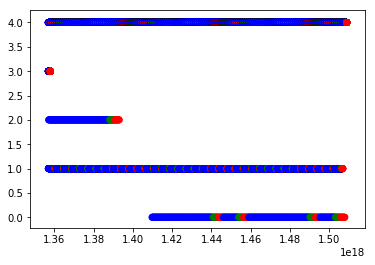

In [8]:
for i, site in enumerate(consumption.SiteId.unique()[:5]):

    to_plot = consumption[(consumption.SiteId == site)]
    
    plt.scatter(to_plot.Timestamp.astype(int),
                [i] * to_plot.shape[0],
                c=to_plot.To_Forecast.replace({'Forecast_1': 'g', 'Forecast_2': 'r', 'Given': 'b'}).values,
                alpha=0.5)

## Generate random index

In [9]:
rng = np.random.RandomState(900)
idx = rng.permutation(np.arange(consumption.shape[0]))
idx

consumption.index = pd.Series(idx, name='obs_id')

consumption.head()

,SiteId,Timestamp,Value,To_Forecast
obs_id,,,,
744519,1,2014-09-03,9.096555e+05,Given
7627564,1,2014-09-04,1.748273e+06,Given
7034705,1,2014-09-05,NaN,Given
5995486,1,2014-09-06,NaN,Given
7326510,1,2014-09-07,NaN,Given


# Generate Sequence ID

In [10]:
# forecast items where the previous item was "Given" indicates transition.
sequences = ((consumption.To_Forecast != 'Given') & (consumption.To_Forecast.shift(1) == 'Given')).cumsum()
consumption['ForecastId'] = sequences

## Save competitions files

In [11]:
consumption = consumption[['SiteId', 'Timestamp', 'ForecastId', 'Value', 'To_Forecast']]

train = consumption[consumption.To_Forecast == 'Given']

test = consumption[consumption.To_Forecast.str.startswith('Forecast')]

public_subset_idx = (test.To_Forecast == 'Forecast_1')

In [12]:
sub_format = test.copy()
sub_format.Value = 0.0

In [14]:
train.drop(["To_Forecast", 'ForecastId'], axis=1, inplace=True)
test.drop("To_Forecast", axis=1, inplace=True)
sub_format.drop("To_Forecast", axis=1, inplace=True)

/Users/bull/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/bull/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [15]:
print(train.shape)
print(test.shape)
print(public_subset_idx.shape)
print(sub_format.shape)

(6559830, 3)
(1309176, 4)
(1309176,)
(1309176, 4)


In [ ]:
train.to_csv(DATA_FINAL / "public" / "train.csv")
sub_format.to_csv(DATA_FINAL / "public" / "submission_format.csv")

test.to_csv(DATA_FINAL / "private" / "test.csv")
public_subset_idx.to_csv(DATA_FINAL / "private" / "public_subset.csv")

In [79]:
train.head()

,SiteId,Timestamp,Value
obs_id,,,
744519,1,2014-09-03,9.096555e+05
7627564,1,2014-09-04,1.748273e+06
7034705,1,2014-09-05,NaN
5995486,1,2014-09-06,NaN
7326510,1,2014-09-07,NaN


In [84]:
print(sub_format.head().to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>SiteId</th>
      <th>Timestamp</th>
      <th>ForecastId</th>
      <th>Value</th>
    </tr>
    <tr>
      <th>obs_id</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1677832</th>
      <td>1</td>
      <td>2015-08-29</td>
      <td>1</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>5379616</th>
      <td>1</td>
      <td>2015-08-30</td>
      <td>1</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>496261</th>
      <td>1</td>
      <td>2015-08-31</td>
      <td>1</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>4567147</th>
      <td>1</td>
      <td>2015-09-01</td>
      <td>1</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>3684873</th>
      <td>1</td>
      <td>2015-09-02</td>
      <td>1</td>
      <td>0.0</td>
    </tr>
  </tbody>
</table>


In [86]:
!head {DATA_FINAL / "public" / "submission_format.csv"}

obs_id,SiteId,Timestamp,ForecastId,Value
1677832,1,2015-08-29 00:00:00,1,0.0
5379616,1,2015-08-30 00:00:00,1,0.0
496261,1,2015-08-31 00:00:00,1,0.0
4567147,1,2015-09-01 00:00:00,1,0.0
3684873,1,2015-09-02 00:00:00,1,0.0
4698291,1,2015-09-03 00:00:00,1,0.0
1129255,1,2015-09-04 00:00:00,1,0.0
834539,1,2015-09-05 00:00:00,1,0.0
3293948,1,2015-09-06 00:00:00,1,0.0


## Test Metric

In [21]:
test.groupby('ForecastId').count().Value.max()

192

In [18]:
%load_ext autoreload
import sys

sys.path.append(str(Path(os.getcwd() + "/../metric/").resolve()))

%autoreload 1
%aimport metrics

In [22]:
tt = pd.read_csv(DATA_FINAL / "public" / "submission_format.csv", index_col=0, parse_dates=["Timestamp"])

/Users/bull/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [47]:
test_vals = test.valuesues
tt_vals = tt.values

In [55]:
# test the submission format
metrics.weighted_rmse(test_vals, tt_vals)

In [56]:
# should be zero
metrics.weighted_rmse(tt_vals, tt_vals)

0.0

# Metadata

 - Remove type of Forecast (competitors can infer from submission formats)
 - Use comma separated instead of semicolon

In [73]:
meta_data = pd.read_csv(DATA_RAW / 'metadata.csv', sep=',', index_col=0)

meta_data.drop(['Type_Forecast'], axis=1, inplace=True)

meta_data.to_csv(DATA_FINAL / "public" / "metadata.csv")

In [81]:
meta_data.head()

,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
SiteId,,,,,,,,,,
1,1387.205119,15.0,18.0,False,False,False,False,False,True,True
2,6098.278376,30.0,18.0,False,False,False,False,False,True,True
3,10556.293605,5.0,18.0,False,False,False,False,False,True,False
5,12541.181277,30.0,18.0,False,False,False,False,False,True,True
6,9150.195373,30.0,18.0,False,False,False,False,False,True,True


# Holidays

 - Only change is to use properly escaped comma separated file instead of semi-colons (for consistency for the competitors)

In [66]:
holidays = pd.read_csv(DATA_RAW / 'Holidays' / 'holidays.csv', sep=';')

holidays.to_csv(DATA_FINAL / "public" / "holidays.csv")

In [87]:
holidays.head()

,Date,Holiday,SiteId
0,2016-01-01,New year,1
1,2016-01-18,"Birthday of Martin Luther King, Jr.",1
2,2016-02-15,Washington's Birthday,1
3,2016-05-30,Memorial Day,1
4,2016-07-04,Independence Day,1


# Weather

 - Coalese into single data frame
 - For each forecast period, drop any weather data during that period (so that it is not improperly used for forecasting. **Note: We are not longer doing this based on the assumption that algos will have a "forecast" available to them of the weather**

In [75]:
dfs = []

for f in (DATA_RAW / 'Weather').glob('*.csv'):
    dfs.append(pd.read_csv(f, sep=';', parse_dates=['Timestamp']))
    
weather = pd.concat(dfs).sort_values(['SiteId', 'Timestamp'])

print(weather.shape)

(20017278, 4)


In [76]:
## Remove weather that overlaps with test periods + sites

In [77]:
# from tqdm import tqdm_notebook

# for forecast_id in tqdm_notebook(sub_format.ForecastId.unique()):
#     f_min = sub_format[sub_format.ForecastId == forecast_id].Timestamp.min()
#     f_max = sub_format[sub_format.ForecastId == forecast_id].Timestamp.max()
#     site_id = sub_format[sub_format.ForecastId == forecast_id].SiteId.values[0]
    
#     weather = weather[~((weather.SiteId == site_id) & (weather.Timestamp > f_min) & (weather.Timestamp < f_max))]
    

In [78]:
weather.to_csv(DATA_FINAL / "public" / "weather.csv")

In [82]:
weather.head()

,Timestamp,Temperature,Distance,SiteId
78064,2013-12-31 19:00:00,-7.2,24.889929,1
86746,2013-12-31 19:00:00,-8.3,23.303097,1
90002,2013-12-31 19:00:00,-7.8,20.952256,1
90003,2013-12-31 19:00:00,-8.0,20.952256,1
100541,2013-12-31 19:34:00,-8.1,16.610602,1


# Json Args

In [68]:
import json
with open(DATA_FINAL/"public"/"read_kwargs.json", "w+") as f:
    json.dump(dict(parse_dates=["Timestamp"]), f)